# Homework 4 (Dev Mody)
## Exercise 2 (MNIST Hand-Written Digits Classification)

In this exercise we return to the handwritten digits in the MNIST dataset that we classified in class using Keras + TensorFlow. However, here, we shall try to classify them directly in Python without using Keras + TensorFlow or Torch. However, it is convenient to import the dataset using Keras + TensorFlow so let's do that before switching completely to Python:

```python
import tensorflow as tf
from autograd import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
```

Note the special version of numpy. In order to use our usual Python Perceptron Routines to let us transform the data:
```python
train_labels.shape = (1,60000)
test_labels.shape=(1,10000)
train_images=(train_images.reshape(60000,784)).T
test_images=(test_images.reshape(10000,784)).T
```
We are now ready to use our usual multiclass perceptron: 
```python
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass perceptron
def multiclass_perceptron(w, x, y, iter):
    # get subset of points
    x_p = x[:, iter]
    y_p = y[:, iter]

    # pre-compute predictions on all points
    all_evals = model(x_p, w)

    # compute maximum across data points
    a = np.max(all_evals,axis = 0)

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)

    # return average
    return cost/float(np.size(y_p))
```

### Exercise 2.1 (Implementing Mini-Batch Gradient Descent):
Implement (in Python) a version of mini-batch gradient descent that takes a batch-size as input `def gradient_descent(g, w, x_train, y_train, alpha, max_its, batch_size)`. For a given batch-size it should determine how many number of batches (`num_batches`) is needed for a full epoch, then construct a batch by sequentially going through the samples in num_batch steps each time using a `batch_size` group of samples. Decide what to do if the `batch_size` is not a divisor of the number of samples, `num_train`. This can be done by setting `num_batches = int(np.ceil(np.divide(num_train,batch_size)))`. For each of the `max_its` number of epochs perform `num_batch` gradient steps.

As you can see in the above implementation of `multiclass_perceptron` you need them to supply the indices for the current batch, `b`. This can be done using `batch_inds = np.arange(b*batch_size, np.minimum((b+1)*batch_size, num_train))`.

You should record the cost-history at each epoch. You can implement all of this by modifying previous versions of gradient descent.

If you're ambitious, you can make things run faster by flattening `g`. You can use `g_flat, unflatten, w = flatten_func(g, w)`. You then have to be careful by using `g_flat` instead of `g`

ANSWER: My implementation is as follows:

In [2]:
import tensorflow as tf
from autograd import numpy as np
from tensorflow.keras.datasets import mnist
import sys
sys.path.append(r"/Users/devmody/Documents/Courses/3ml3/homeworks/homework4/MLRPlotting")
import matplotlib.pyplot as plt
from MLRPlotting import static_plotter
from autograd.misc.flatten import flatten_func
from autograd import grad as gradient

static_plotter = static_plotter.Visualizer()

# Load and preprocess data - NORMALIZE
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_labels.shape = (1, 60000)
test_labels.shape = (1, 10000)
train_images = (train_images.reshape(60000, 784)).T
test_images = (test_images.reshape(10000, 784)).T

# Model definition
def model(x, w):
    a = w[0] + np.dot(x.T, w[1:])  # (10, 784) × (784, batch_size) = (10, batch_size)
    return a.T

# Cost function
def multiclass_perceptron(w,x,y,iter):
    x_p = x[:,iter]
    y_p = y[:,iter]
    all_evals = model(x_p,w)
    a =  np.max(all_evals,axis = 0)        
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)
    return cost/float(np.size(y_p))

def minibatch_gradient_descent(g, w, x_train, y_train, alpha, max_its, batch_size):
    num_train = x_train.shape[1]
    w_hist = [w] 
    ind = np.arange(num_train)
    c_hist = [g(w, x_train, y_train, ind)]
    
    for epoch in range(max_its):

        num_batches = int(np.ceil(num_train / batch_size))
        
        for b in range(num_batches):
            batch_inds = np.arange(b * batch_size, min(b * batch_size + batch_size, num_train))
            
            def g_batch(current_w):
                return g(current_w, x_train, y_train, batch_inds)
            

            grad_w = gradient(g_batch)(w)
            
            w -= alpha * grad_w
        
        epoch_cost = g(w, x_train, y_train, ind)
        c_hist.append(epoch_cost)
        w_hist.append(w.copy())
        print(f"Epoch {epoch + 1}/{max_its}, Cost: {epoch_cost}")

    return w_hist, c_hist

### Exercise 2.2 (Testing Mini-Batch Gradient Descent):
Use your mini-batch gradient descent with a number of epochs, `max_its=5`, and a random starting vector `w = 0.1*np.random.randn(N+1,C)` where `N,C` have their usual definition. Use a learning rate `alpha=0.001`. Make 2 separate runs, first with a batchsize of 200 then with a batchsize equal to the number of samples (full batch). Plot the cost histories versus the number of epochs. Which batchsize performs the best?

ANSWER: The experiment described above is as follows. As we can see, the batch size of 200 performs better than the full batch size. This is because the cost remains lower and more stable throughout each epoch for the batch size of 200. The full batch size has a higher cost and is more volatile.

Epoch 1/5, Cost: 17.19142527835496
Epoch 2/5, Cost: 15.549072533666129
Epoch 3/5, Cost: 13.768968710883659
Epoch 4/5, Cost: 12.080936020794246
Epoch 5/5, Cost: 11.213862303509357
Epoch 1/5, Cost: 308.3342829317243
Epoch 2/5, Cost: 208.9959235065264
Epoch 3/5, Cost: 168.50103701678404
Epoch 4/5, Cost: 154.9902640943773
Epoch 5/5, Cost: 109.14965255287188
11.213862303509357 109.14965255287188


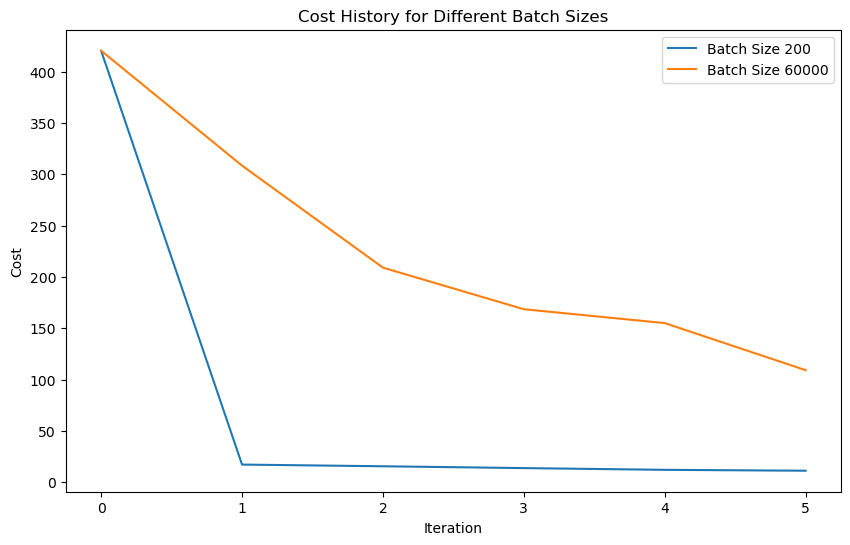

In [3]:
alpha = 0.001
max_its = 5
N = train_images.shape[0]
C = 10
w = 0.1*np.random.randn(N+1,C)
batchsize1 = 200
batchsize2 = train_images.shape[1]

weight_1, cost_1 = minibatch_gradient_descent(multiclass_perceptron, w.copy(), train_images, train_labels, alpha, max_its, batchsize1)
weight_2, cost_2 = minibatch_gradient_descent(multiclass_perceptron, w.copy(), train_images, train_labels, alpha, max_its, batchsize2)

print(cost_1[-1], cost_2[-1])
plt.figure(figsize=(10, 6))
plt.plot(cost_1, label='Batch Size 200')
plt.plot(cost_2, label='Batch Size {}'.format(batchsize2))
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History for Different Batch Sizes')
plt.legend()
plt.show()

### Exercise 2.3 (Misclassification Experiment):

Use the best set of weights you obtained to make a histogram of the percentage of misclassified samples as a function of the digit (0-9). Is there a digit that is more misclassified than others?

ANSWER: The histogram of the percentage of misclassified samples as a function of the digit is as follows. The digit 8 is the most misclassified digit followed by 8, and 7. Please note that the percentage of misclassifications varies per training session. 

0 :1.8065169677528279%
1 :1.9133788193414418%
2 :12.336354481369586%
3 :9.753710650791062%
4 :12.153372132831223%
5 :18.280760007378714%
6 :4.613044947617438%
7 :16.552274541101355%
8 :30.165783626730473%
9 :6.70700958144226%


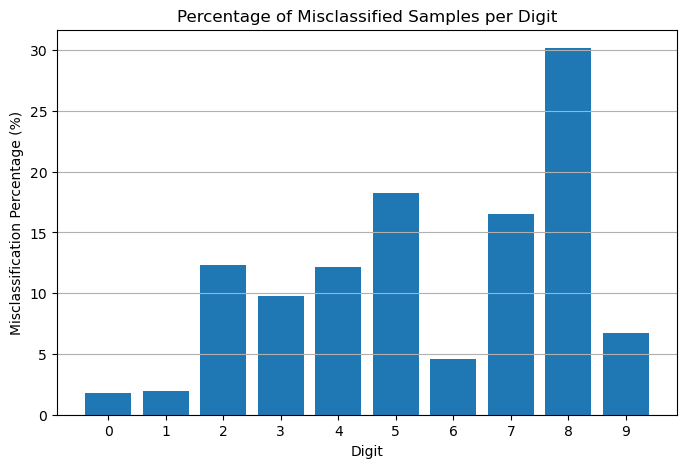

In [7]:

def find_best_weights(weight_history, cost_history):
    weight_history = np.array(weight_history)
    cost_history = np.array(cost_history)

    best_cost = np.argmin(cost_history)

    return weight_history[best_cost]

def miscount (w, x, y):
    a = model(x, w)
    predictions = np.argmax(a, axis=0)
    y_flat = y.flatten().astype(int)
    miscounts = np.zeros(10)
    total_counts = np.zeros(10)
    
    for digit in range (10):
        inds = np.where(y_flat == digit)[0]
        total_counts[digit] = len(inds)
        if len(inds) > 0:
            miscounts[digit] = np.sum(predictions[inds] != y_flat[inds])
    return (miscounts / total_counts) * 100

best_weights = find_best_weights(weight_1, cost_1)

percentage = miscount(best_weights, train_images, train_labels)
for x in range(len(percentage)):
    print(x, ":" + str(percentage[x]) + "%")
plt.figure(figsize=(8, 5))
plt.bar(range(10), percentage, tick_label=range(10))
plt.xlabel('Digit')
plt.ylabel('Misclassification Percentage (%)')
plt.title('Percentage of Misclassified Samples per Digit')
plt.grid(axis='y')
plt.show()